### Core collapse

Heat trasnfer due to self interactions can lead to core collapse of SIDM halos, particularly at high cross sections. This process can be accelerated if the halos exist in a tidal field (i.e. are subhalos). 

To run this notebook, you'll need to install the software package pyHalo https://github.com/dangilman/pyHalo

In [1]:
from sidmpy.CrossSections.power_law import PowerLaw
from sidmpy.CrossSections.tchannel import TChannel
from sidmpy.CrossSections.velocity_independent import VelocityIndependentCrossSection
from sidmpy.core_collapse_timescale import *
from sidmpy.Solver.util import nfw_velocity_dispersion, nfw_circular_velocity
from matplotlib import cm
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15

## Timescales for subhalos and field halos

Eventually, all SIDM halos should undergoe core collapse. The timescale for this process depends on the strength of the interaction cross section and other processes like tidal stripping. Depending on these factors, it can be much longer than, comparable, or shorter than the age of the Universe. 

We will use a characteristic timescale for core collapse

\begin{equation}
t_c = \frac{1}{3 \rho_s \langle \sigma\left(v\right) v \rangle }
\end{equation}

### Core collapse timescale as a function of halo mass and redshift.

#### Note: this cell requires the software package pyHalo

Help on function evolution_timescale_scattering_rate in module sidmpy.core_collapse_timescale:

evolution_timescale_scattering_rate(rho_s, v_rms, cross_section, rescale=1.0)
    Evaluates the timescale for the evolution of SIDM profiles using the scattering rate
    average proportional to
    
    <sigma(v) v>
    
    given by Equation 4 in this paper https://arxiv.org/pdf/2102.09580.pdf
    with an additional factor of 3
    
    :param rho_s: the central density normalization of the collisionless NFW profile of the same mass
    :param v_rms: the velocity dispersion of the halo
    :param cross_section: an instance of the cross section model
    :return: the characteristic timescale for structural evolution in Gyr



No handles with labels found to put in legend.


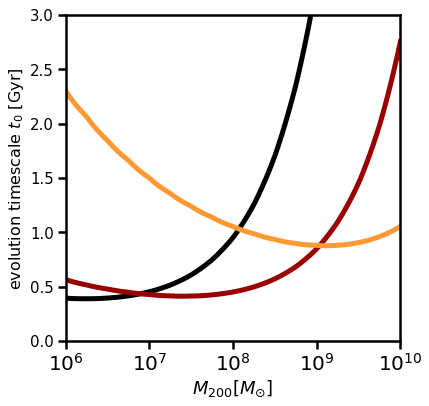

In [3]:
from pyHalo.Halos.lens_cosmo import LensCosmo
import numpy as np
from sidmpy.Solver.util import nfw_velocity_dispersion, nfw_mass_from_velocity_dispersion
import matplotlib.pyplot as plt
from sidmpy.sidmpy import solve_rho_with_interpolation, solve_sigmav_with_interpolation
help(evolution_timescale_scattering_rate)
lc = LensCosmo()
t1 = []
t2 = []
t3 = []

kwargs_cross_section_1 = {'norm': 35., 'v_ref': 10}
kwargs_cross_section_2 = {'norm': 20., 'v_ref': 25}
kwargs_cross_section_3 = {'norm': 5., 'v_ref': 100}
cross_section_1 = TChannel(**kwargs_cross_section_1)
cross_section_2 = TChannel(**kwargs_cross_section_2)
cross_section_3 = TChannel(**kwargs_cross_section_3)
cmap = cm.gist_heat
z = 0.
m = np.logspace(6, 10, 100)

for mi in m:
    
    c = lc.NFW_concentration(mi, z, scatter=False)
    rhos, rs, _ = lc.NFW_params_physical(mi, c, z)
    v1 = solve_sigmav_with_interpolation(mi, z, 0., 'TCHANNEL', kwargs_cross_section_1)
    v2 = solve_sigmav_with_interpolation(mi, z, 0., 'TCHANNEL', kwargs_cross_section_2)
    v3 = solve_sigmav_with_interpolation(mi, z, 0., 'TCHANNEL', kwargs_cross_section_3)
    
    t0 = evolution_timescale_scattering_rate(rhos, v1, cross_section_1, rescale=1.)
    t1.append(t0)
    
    t0 = evolution_timescale_scattering_rate(rhos, v2, cross_section_2, rescale=1.)
    t2.append(t0)
    
    t0 = evolution_timescale_scattering_rate(rhos, v3, cross_section_3, rescale=1.)
    t3.append(t0)

fig = plt.figure(1)
fig.set_size_inches(6, 6)
ax = plt.subplot(111)
ax.plot(np.log10(m), t1, color='k', lw=5)
ax.plot(np.log10(m), t2, color=cmap(0.4), lw=5)
ax.plot(np.log10(m), t3, color=cmap(0.8), lw=5)
ax.set_xlabel(r'$M_{200} \left[M_{\odot}\right]$', fontsize=18)
ax.set_ylabel('evolution timescale '+r'$t_0 \ \left[\rm{Gyr}\right]$', fontsize=16)
ax.set_xticks([6, 7, 8, 9, 10])
ax.set_xticklabels([r'$10^{6}$', r'$10^{7}$', r'$10^{8}$', r'$10^{9}$', r'$10^{10}$'], fontsize=20)
ax.set_yticks([0., 0.5, 1., 1.5, 2, 2.5, 3])
ax.set_ylim(0, 3)
ax.set_xlim(6,10)
ax.legend(frameon=False, fontsize=14)